In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/IDS/data/combined_dataset.csv')
print("Toate coloanele disponibile în dataset:")
print(df.columns.tolist())


Toate coloanele disponibile în dataset:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Fla

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_recall_curve
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, GaussianNoise
from tensorflow.keras import regularizers

# --- Reproducibilitate ---
np.random.seed(42)
tf.random.set_seed(42)

DATA_PATH = '/content/drive/MyDrive/IDS/data/combined_dataset.csv'
MODEL_DIR = '/content/drive/MyDrive/IDS/models'
os.makedirs(MODEL_DIR, exist_ok=True)

SELECTED_FEATURES = [
    'Destination Port', 'Flow Duration',
    'Total Length of Fwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Bwd Header Length', 'Max Packet Length', 'Packet Length Std',
    'Average Packet Size', 'Avg Bwd Segment Size',
    'Subflow Bwd Packets', 'Subflow Bwd Bytes',
    'Flow Bytes/s', 'Flow IAT Mean',
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
    'ECE Flag Count', 'CWE Flag Count', 'Fwd Header Length'
]
# --- Load data ---
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
label_col = 'Label' if 'Label' in df.columns else ' Label'
labels = df[label_col]


# --- Features final ---
features = df[SELECTED_FEATURES].copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
labels = labels.loc[features.index]

# --- Convert to numpy ---
X = features.astype(np.float32).values
y = np.where(labels == 'BENIGN', 0, 1)

# --- Split benign/attack ---
X_benign = X[y == 0]
X_attack = X[y == 1]

# --- Test sets ---
TEST_BENIGN_SIZE = 200_000
TEST_ATTACK_SIZE = 200_000
idx_benign_test = np.random.choice(len(X_benign), TEST_BENIGN_SIZE, replace=False)
idx_attack_test = np.random.choice(len(X_attack), TEST_ATTACK_SIZE, replace=False)

X_benign_test = X_benign[idx_benign_test]
X_attack_test = X_attack[idx_attack_test]

# --- Train/val sets (benign only) ---
X_benign_train_val = np.delete(X_benign, idx_benign_test, axis=0)
X_train, X_val = train_test_split(X_benign_train_val, test_size=0.2, random_state=42)

# --- Cap train samples ---
MAX_TRAIN_SAMPLES = 1_500_000
if len(X_train) > MAX_TRAIN_SAMPLES:
    idx = np.random.choice(len(X_train), MAX_TRAIN_SAMPLES, replace=False)
    X_train = X_train[idx]

# --- Final test set ---
X_test = np.concatenate([X_benign_test, X_attack_test])
y_test = np.concatenate([np.zeros(len(X_benign_test)), np.ones(len(X_attack_test))])
perm = np.random.permutation(len(X_test))
X_test, y_test = X_test[perm], y_test[perm]

# --- Normalize ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- TF datasets ---
def make_tf_dataset(X, batch_size=512, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, X))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_tf_dataset(X_train_scaled)
val_ds = make_tf_dataset(X_val_scaled, shuffle=False)

input_dim = X_train_scaled.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    GaussianNoise(0.2),

    # --- Encoder ---
    Dense(32, kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    LeakyReLU(0.05),
    Dropout(0.08),

    Dense(16, kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    LeakyReLU(0.05),
    Dropout(0.08),

    Dense(12, name="bottleneck",activation="linear",kernel_regularizer=regularizers.l1(1e-5)),
    Dropout(0.08),

    # --- Decoder (simetric-ish) ---
    Dense(16),
    BatchNormalization(),
    LeakyReLU(0.05),
    Dropout(0.05),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(0.05),

    Dense(input_dim, activation='sigmoid')  # pt MinMaxScaler
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # pași mai mici pe zgomot
    loss=tf.keras.losses.Huber(delta=0.5)                    # robust la outlieri
)


# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# --- Train ---
history = model.fit(
    train_ds, validation_data=val_ds, epochs=100,
    batch_size=256, shuffle=True,
    callbacks=[early_stop, reduce_lr], verbose=2
)

# --- Reconstruction errors (Huber) ---
recon = model.predict(X_test_scaled, verbose=0)
huber = tf.keras.losses.Huber(delta=0.5, reduction='none')
errors = huber(tf.convert_to_tensor(X_test_scaled, dtype=tf.float32),
               tf.convert_to_tensor(recon, dtype=tf.float32))
test_errors = errors.numpy()

# --- Threshold F1-optimal ---
precision, recall, thresholds = precision_recall_curve(y_test, test_errors)
balance_scores = precision + recall - 1
best_idx = np.argmax(balance_scores)
best_threshold = thresholds[best_idx]

y_pred = (test_errors > best_threshold).astype(int)
print(f"Optimal Threshold (balance): {best_threshold:.6f}")
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# --- Plot pentru vizualizare ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(test_errors[y_test==0], bins=100, alpha=0.6, label='BENIGN')
plt.hist(test_errors[y_test==1], bins=100, alpha=0.6, label='ATTACK')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.6f}')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.show()

# --- Save ---
model.save(os.path.join(MODEL_DIR, 'autoencoder_optimal_tf_8.keras'))
joblib.dump(scaler, os.path.join(MODEL_DIR, 'ae_scaler_optimal.pkl'))



[RESULTS]
              precision    recall  f1-score   support

         0.0     0.7852    0.8885    0.8336    200000
         1.0     0.8716    0.7569    0.8102    200000

    accuracy                         0.8227    400000
   macro avg     0.8284    0.8227    0.8219    400000
weighted avg     0.8284    0.8227    0.8219    400000

Accuracy: 0.8227
Best threshold (F1-optimal): 0.001418


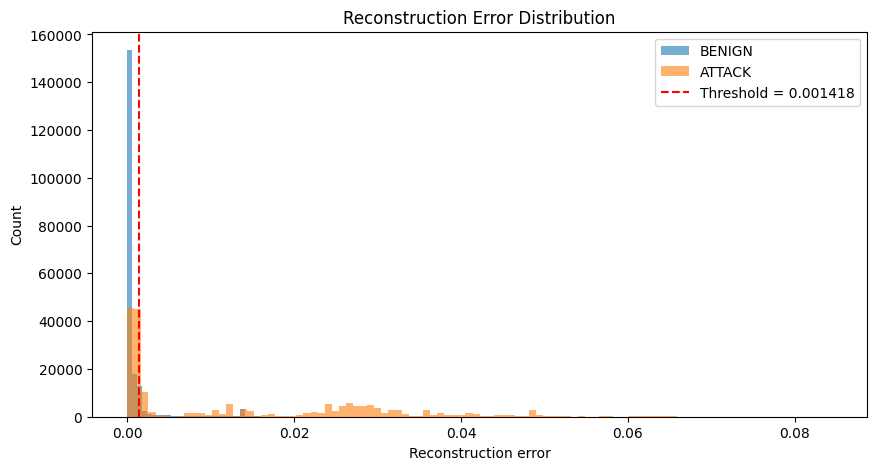

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Input, Dense, BatchNormalization,
                                     LeakyReLU, Dropout, GaussianNoise)
from tensorflow.keras import regularizers

np.random.seed(42)
tf.random.set_seed(42)

# --- Configurații ---
SELECTED_FEATURES = [
    'Destination Port', 'Flow Duration',
    'Total Length of Fwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Bwd Header Length', 'Max Packet Length', 'Packet Length Std',
    'Average Packet Size', 'Avg Bwd Segment Size',
    'Subflow Bwd Packets', 'Subflow Bwd Bytes',
    'Flow Bytes/s', 'Flow IAT Mean',
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
    'ECE Flag Count', 'CWE Flag Count', 'Fwd Header Length'
]

DATA_PATH = '/content/drive/MyDrive/IDS/data/combined_dataset.csv'
MODEL_DIR = '/content/drive/MyDrive/IDS/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Load & preprocess data ---
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
label_col = 'Label' if 'Label' in df.columns else ' Label'
labels = df[label_col]

features = df[SELECTED_FEATURES].copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
labels = labels.loc[features.index]

X = features.astype(np.float32).values
y = np.where(labels == 'BENIGN', 0, 1)

X_benign = X[y == 0]
X_attack = X[y == 1]

TEST_BENIGN_SIZE = 200_000
TEST_ATTACK_SIZE = 200_000
assert len(X_benign) > TEST_BENIGN_SIZE, "Insufficient benign samples."
assert len(X_attack) > TEST_ATTACK_SIZE, "Insufficient attack samples."

# --- Extract test sets ---
idx_benign_test = np.random.choice(len(X_benign), TEST_BENIGN_SIZE, replace=False)
idx_attack_test = np.random.choice(len(X_attack), TEST_ATTACK_SIZE, replace=False)
X_benign_test = X_benign[idx_benign_test]
X_attack_test = X_attack[idx_attack_test]

# --- Rest for train/val ---
X_benign_train_val = np.delete(X_benign, idx_benign_test, axis=0)
X_attack_train_val = np.delete(X_attack, idx_attack_test, axis=0)

# --- Split benign only for training ---
X_train, X_val = train_test_split(X_benign_train_val, test_size=0.2, random_state=42)

MAX_TRAIN_SAMPLES = 1_500_000
if len(X_train) > MAX_TRAIN_SAMPLES:
    idx = np.random.choice(len(X_train), MAX_TRAIN_SAMPLES, replace=False)
    X_train = X_train[idx]

# --- Final test set ---
X_test = np.concatenate([X_benign_test, X_attack_test])
y_test = np.concatenate([np.zeros(len(X_benign_test)), np.ones(len(X_attack_test))])
perm = np.random.permutation(len(X_test))
X_test, y_test = X_test[perm], y_test[perm]

# --- Normalize ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, '/content/drive/MyDrive/IDS/models/ae_scaler_optimal.pkl')

model = load_model('/content/drive/MyDrive/IDS/models/autoencoder_optimal_tf_8.keras')

huber = tf.keras.losses.Huber(delta=0.5, reduction='none')

recon = model.predict(X_test_scaled, verbose=0)
test_errors = huber(tf.convert_to_tensor(X_test_scaled), tf.convert_to_tensor(recon)).numpy()

# --- Threshold optimization ---
precision, recall, thresholds = precision_recall_curve(y_test, test_errors)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

# --- Evaluation ---
y_pred = (test_errors > best_threshold).astype(int)
print("\n[RESULTS]")
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Best threshold (F1-optimal): {best_threshold:.6f}")

# --- Plot errors ---
plt.figure(figsize=(10, 5))
plt.hist(test_errors[y_test == 0], bins=100, alpha=0.6, label='BENIGN')
plt.hist(test_errors[y_test == 1], bins=100, alpha=0.6, label='ATTACK')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.6f}')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import Huber
import tensorflow as tf
import joblib
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = '/content/drive/MyDrive/IDS/data/combined_dataset.csv'
MODEL_PATH = '/content/drive/MyDrive/IDS/models/autoencoder_optimal_tf_8.keras'
SCALER_PATH = '/content/drive/MyDrive/IDS/models/ae_scaler_optimal.pkl'
DATA_DIR = '/content/drive/MyDrive/IDS/data'

features = [
    'Destination Port', 'Flow Duration',
    'Total Length of Fwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Bwd Header Length', 'Max Packet Length', 'Packet Length Std',
    'Average Packet Size', 'Avg Bwd Segment Size',
    'Subflow Bwd Packets', 'Subflow Bwd Bytes',
    'Flow Bytes/s', 'Flow IAT Mean',
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
    'ECE Flag Count', 'CWE Flag Count', 'Fwd Header Length'
]

# Încarcă modelul și scalerul
autoencoder = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# Creează encoderul (primele 10 layere din modelul AE)
input_layer = Input(shape=(len(features),))
x = input_layer
for i in range(10):
    x = autoencoder.layers[i](x)
encoder = Model(inputs=input_layer, outputs=x)

# Procesare în chunks
chunk_size = 50000
augmented_list = []
label_list = []

scaler_err = MinMaxScaler()


reader = pd.read_csv(DATA_PATH, chunksize=chunk_size)
for idx, chunk in enumerate(reader):
    print(f"Processing chunk {idx+1}...")

    chunk.columns = chunk.columns.str.strip()
    label_col = 'Label' if 'Label' in chunk.columns else ' Label'

    X = chunk[features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    y = chunk[label_col].loc[X.index]
    y = y.map(lambda v: 0 if v in ['BENIGN', 'Normal'] else 1)

    X_scaled = scaler.transform(X.values)

    # Cod latent
    X_latent = encoder.predict(X_scaled, verbose=0)

    augmented_list.append(X_latent)
    label_list.append(y.to_numpy())

# Concatenează totul
X_final = np.concatenate(augmented_list, axis=0)
y_final = np.concatenate(label_list, axis=0)

# Salvează
np.save(os.path.join(DATA_DIR, "latent_with_re.npy"), X_final)
np.save(os.path.join(DATA_DIR, "labels.npy"), y_final)

print(f"Saved {X_final.shape[0]} samples with {X_final.shape[1]} features (latent + RE).")


Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43...
Processing chunk 44.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/IDS/models/autoencoder_optimal_tf_8.keras')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_3                │ (None, 27)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,679 (41.72 KB)

 Trainable params: 3,487 (13.62 KB)

 Non-trainable params: 216 (864.00 B)

 Optimizer params: 6,976 (27.25 KB)

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import joblib

# === Căi fișiere ===
X_PATH = '/content/drive/MyDrive/IDS/data/latent_with_re.npy'
Y_PATH = '/content/drive/MyDrive/IDS/data/labels.npy'
MODEL_PATH = '/content/drive/MyDrive/IDS/models/svm_calibrated_filtered.pkl'


# === Încărcare date ===
X_full = np.load(X_PATH)
y_full = np.load(Y_PATH)

# === Split train / val / test ===
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Train set:", np.bincount(y_train))
print("Validation set:", np.bincount(y_val))
print("Test set:", np.bincount(y_test))

# === SMOTE pe datele de antrenament ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"SMOTE: {np.bincount(y_train)} -> {np.bincount(y_train_res)}")

# === LinearSVC + GridSearch ===
svc = LinearSVC(dual=False, max_iter=20000, tol=1e-4, class_weight='balanced')
param_grid = {'C': [0.001, 0.005, 0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(svc, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_train_res, y_train_res)

print(f"Best SVM params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# === Calibrare pe validation set ===
calibrator = CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv='prefit')
calibrator.fit(X_val, y_val)

# === Optimizare prag pe validation ===
scores_val = calibrator.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 100)
best_thr, best_f1 = 0, 0

for t in thresholds:
    preds = (scores_val >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print(f"\n✅ Best threshold on validation: {best_thr:.4f} with F1={best_f1:.4f}")

# === Evaluare pe test ===
scores_test = calibrator.predict_proba(X_test)[:, 1]
y_pred = (scores_test >= best_thr).astype(int)

print(f"\n📊 Classification report on TEST with threshold={best_thr:.4f}:")
print(classification_report(y_test, y_pred))

# === Salvare model calibrat + prag ===
joblib.dump({'model': calibrator, 'threshold': best_thr}, MODEL_PATH)


Train set: [1362791  333934]
Validation set: [454264 111311]
Test set: [454265 111311]
SMOTE: [1362791  333934] -> [1362791 1362791]
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM params: {'C': 0.001}
Best CV F1: 0.7638


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



✅ Best threshold on validation: 0.1818 with F1=0.5393

📊 Classification report on TEST with threshold=0.1818:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79    454265
           1       0.40      0.85      0.54    111311

    accuracy                           0.71    565576
   macro avg       0.67      0.77      0.67    565576
weighted avg       0.84      0.71      0.74    565576



['/content/drive/MyDrive/IDS/models/svm_calibrated_filtered.pkl']

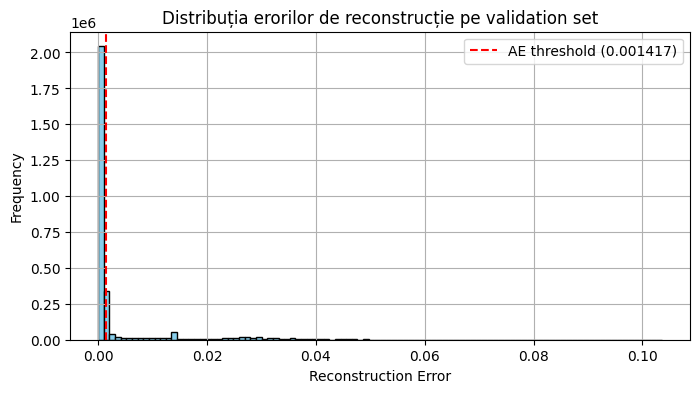

📊 Mean RE: 3.446036e-03
📊 Std RE:  8.923405e-03
📊 Min/Max: 3.389332e-07 / 1.035762e-01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Încarcă erorile de reconstrucție (înlocuiește cu path-ul tău) ===
reconstruction_errors = np.load("/content/drive/MyDrive/IDS/data/reconstruction_errors.npy")


# === Vizualizează distribuția ===
plt.figure(figsize=(8,4))
plt.hist(reconstruction_errors, bins=100, color='skyblue', edgecolor='black')
plt.axvline(x=0.001417, color='red', linestyle='--', label='AE threshold (0.001417)')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribuția erorilor de reconstrucție pe validation set")
plt.legend()
plt.grid(True)
plt.show()

# === Statistici utile ===
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

print(f"📊 Mean RE: {mean_error:.6e}")
print(f"📊 Std RE:  {std_error:.6e}")
print(f"📊 Min/Max: {np.min(reconstruction_errors):.6e} / {np.max(reconstruction_errors):.6e}")
